# Definiëren van hulpfuncties


Importeer libraries:

In [1]:
import numpy as np
from numpy import sin, cos
import scipy
from math import log
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time as clock
import asyncio
from matplotlib import animation
from IPython.display import Video
import time as system_time
import seaborn as sns
import os
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.ticker import StrMethodFormatter

Definieer de constanten / configuratie:

In [2]:
G = 9.81
sns.set_theme()

Definieer de afgeleiden als een stelsel van 4 differentiaalvergelijkingen van de eerste order:

In [3]:
def derivs(state, t, m1, m2, l1, l2):
    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (m1 + m2) * l1 - m2 * l1 * cos(delta) * cos(delta)
    dydx[1] = ((m2 * l1 * state[1] * state[1] * sin(delta) * cos(delta)
                + m2 * G * sin(state[2]) * cos(delta)
                + m2 * l2 * state[3] * state[3] * sin(delta)
                - (m1 + m2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (l2 / l1) * den1
    dydx[3] = ((- m2 * l2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (m1 + m2) * G * sin(state[0]) * cos(delta)
                - (m1 + m2) * l1 * state[1] * state[1] * sin(delta)
                - (m1 + m2) * G * sin(state[2]))
               / den2)
    
    return dydx

Definieer een functie voor het genereren van data vanuit de initiële waarden:

In [4]:
def get_resulting_array(t, theta1, theta1_dot, theta2, theta2_dot, m1, m2, l1, l2):
    state = [theta1, theta1_dot, theta2, theta2_dot]
    results = scipy.integrate.odeint(lambda S, t : derivs(S, t, m1, m2, l1, l2), state, t)
    return results

Definieer een functie voor het omzetten van data naar cartesische coördinaten:

In [5]:
def get_coordinates(results, l1, l2):
    theta1 = results[:,0]
    theta2 = results[:,2]
    
    return (
        l1*np.sin(theta1),
        -l1*np.cos(theta1),
        l1*np.sin(theta1) + l2*np.sin(theta2),
        -l1*np.cos(theta1) - l2*np.cos(theta2)
    )

Definieer en functie voor de afstanden tussen twee slingers:

In [6]:
def get_differences(results1, results2):
    return np.abs(np.subtract(results1, results2))

Definieer een functie om de Lyapunov exponenten te berekenen uit twee resultaten:

In [7]:
def get_lyapunov_values(t, differences):
    thetha1_differences = differences[:, 0]
    lyapunov = [0]
    
    for index, time in enumerate(t):
        if (index == 0):
            continue
        exponent = (1 / time) * log(thetha1_differences[index] / thetha1_differences[0])
        lyapunov.append(exponent)
        
    return lyapunov

Definieer een functie om Lyapuov exponenten te berekenen uit twee slingers:

Maak een class om te helpen bij het loggen van laadtijden:

In [8]:
class TimeLogger:
    
    def __init__(self, total_frames, name):
        self.total_frames = total_frames
        self.name = name
        self.current_frame = 0
        self.last_result = 0
        self.gain = 0.1
        self.start_time = system_time.time()
        
    def update(self):
        self.current_frame += 1
        
        now = system_time.time()
        dt = now - self.start_time
        self.start_time = now
        
        if (self.last_result == 0):
            self.last_result = dt
                
        filtered_dt = self.gain * dt + (1 - self.gain) * self.last_result
        self.last_result = filtered_dt
            
        frames_remaining = self.total_frames - self.current_frame
        time_remaining = frames_remaining * filtered_dt
        time_remaining_formatted = clock.strftime("%H:%M:%S", clock.gmtime(time_remaining))
        print(str(self.name) + " completion: " + (str(round(self.current_frame / self.total_frames * 1000) / 10)) + "%, time remaining: " + str(time_remaining_formatted), end='\r')

# Genereer data

Regressie van twee slingers:


In [14]:
# if (os.path.exists("data/regression_pendulums.pkl") or os.path.exists("data/regression_distance.pkl") or os.path.exists("data/regression_lyapunov")):
#     raise UserWarning("Verwijder de bestaande data voordat je nieuwe genreert!")
    
# Configuratie
t_end = 20
dt = 0.002
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
m1 = 1
m2 = 1
theta1 = math.radians(90)
theta2 = math.radians(90)
dtheta = math.radians(0.01)

# Bereken resulterende data
results1 = get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2)
results2 = get_resulting_array(t, theta1 + dtheta, 0, theta2 + dtheta, 0, m1, m2, l1, l2)

distances = get_differences(results1, results2)
lyapunov_values = get_lyapunov_values(t, distances)

# Maak dataframes aan
pendulums_dataframe = pd.DataFrame({"Slinger 1": results1[:, 0], "Slinger 2": results2[:, 0]}, t)
distance_dataframe = pd.DataFrame(distances[:, 0], t)
lyapunov_dataframe = pd.DataFrame(lyapunov_values, t)

# Sla dataframes op
pendulums_dataframe.to_pickle("data/regression_pendulums.pkl")
distance_dataframe.to_pickle("data/regression_distance.pkl")
lyapunov_dataframe.to_pickle("data/regression_lyapunov.pkl")

ValueError: Data must be 1-dimensional, got ndarray of shape (10000, 4) instead

Lyapunov exponenten bij verschillende massa's:

In [14]:
lyapunov_masses_output_path = "data/lyapunov_masses.pkl"

# if (os.path.exists("data/lyapunov_masses.pkl")):
#     raise UserWarning("Verwijder de bestaande data voordat je nieuwe genreert!")

# Configuratie
t_end = 30
dt = 0.02
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
dtheta = 0.02

M_array = np.arange(0.5, 5, 0.5)
theta_array = np.linspace(0.1 * math.pi, 0.5 * math.pi, 10)
result_matrix = []

timelogger = TimeLogger(len(M_array), "Generating data")

for index, m1 in enumerate(M_array):
    result_row = []
    
    for m2 in M_array:
        lyapunov_sum = 0
        
        for theta in theta_array:
            results1 = get_resulting_array(t, theta - dtheta / 2, 0, theta - dtheta / 2, 0, m1, m2, l1, l2)
            results2 = get_resulting_array(t, theta + dtheta / 2, 0, theta + dtheta / 2, 0, m1, m2, l1, l2)
            distances = get_differences(results1, results2)
            lyapunov_values = get_lyapunov_values(t, distances)

            lyapunov_sum += max(lyapunov_values)
            
        result_row.append(lyapunov_sum / len(theta_array))
    timelogger.update()
        
    result_matrix.append(result_row)

# Maak dataframes aan
result_dataframe = pd.DataFrame(result_matrix, M_array, M_array)

# Sla dataframe op
result_dataframe.to_pickle(lyapunov_masses_output_path)

Lyapunov exponenten bij verschillende lengtes:

In [16]:
lyapunov_lengths_output_path = "data/lyapunov_lengths.pkl"

# if (os.path.exists("data/lyapunov_masses.pkl")):
#     raise UserWarning("Verwijder de bestaande data voordat je nieuwe genreert!")

# Configuratie
t_end = 30
dt = 0.02
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
m1 = 1
m2 = 1
dtheta = 0.02

L_array = np.arange(0.5, 30, 0.5)
theta_array = np.linspace(0.1 * math.pi, 0.5 * math.pi, 10)
result_matrix = []

timelogger = TimeLogger(len(L_array), "Generating data")

for index, l1 in enumerate(L_array):
    result_row = []
    
    for l2 in L_array:
        lyapunov_sum = 0
        
        for theta in theta_array:
            results1 = get_resulting_array(t, theta - dtheta / 2, 0, theta - dtheta / 2, 0, m1, m2, l1, l2)
            results2 = get_resulting_array(t, theta + dtheta / 2, 0, theta + dtheta / 2, 0, m1, m2, l1, l2)
            distances = get_differences(results1, results2)
            lyapunov_values = get_lyapunov_values(t, distances)

            lyapunov_sum += max(lyapunov_values)
            
        result_row.append(lyapunov_sum / len(theta_array))
    timelogger.update()
        
    result_matrix.append(result_row)

# Maak dataframes aan
result_dataframe = pd.DataFrame(result_matrix, L_array, L_array)

# Sla dataframe op
result_dataframe.to_pickle(lyapunov_lengths_output_path)

Lyapunov bij verschillende startsnelheden

In [43]:
# if (os.path.exists("data/lyapunov_masses.pkl")):
#     raise UserWarning("Verwijder de bestaande data voordat je nieuwe genreert!")

# Configuratie
t_end = 30
dt = 0.02
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
m1 = 1
m2 = 1
dtheta = 0.02

theta_dot_array = np.arange(0.5, 4, 0.5)
theta_array = np.linspace(0.1 * math.pi, 0.5 * math.pi, 10)
result_matrix = []

timelogger = TimeLogger(len(theta_dot_array), "Generating data")

for index, theta1_dot in enumerate(theta_dot_array):
    result_row = []
    
    for theta2_dot in theta_dot_array:
        lyapunov_sum = 0
        
        for theta in theta_array:
            results1 = get_resulting_array(t, theta - dtheta / 2, theta1_dot, theta - dtheta / 2, theta2_dot, m1, m2, l1, l2)
            results2 = get_resulting_array(t, theta + dtheta / 2, theta1_dot, theta + dtheta / 2, theta1_dot, m1, m2, l1, l2)
            distances = get_differences(results1, results2)
            lyapunov_values = get_lyapunov_values(t, distances)

            lyapunov_sum += max(lyapunov_values)
            
        result_row.append(lyapunov_sum / len(theta_array))
    timelogger.update()
        
    result_matrix.append(result_row)

# Maak dataframes aan
result_dataframe = pd.DataFrame(result_matrix, theta_dot_array, theta_dot_array)

# Sla dataframe op
result_dataframe.to_pickle("data/lyapunov_velocity.pkl")

# Grafieken

Poincare section:

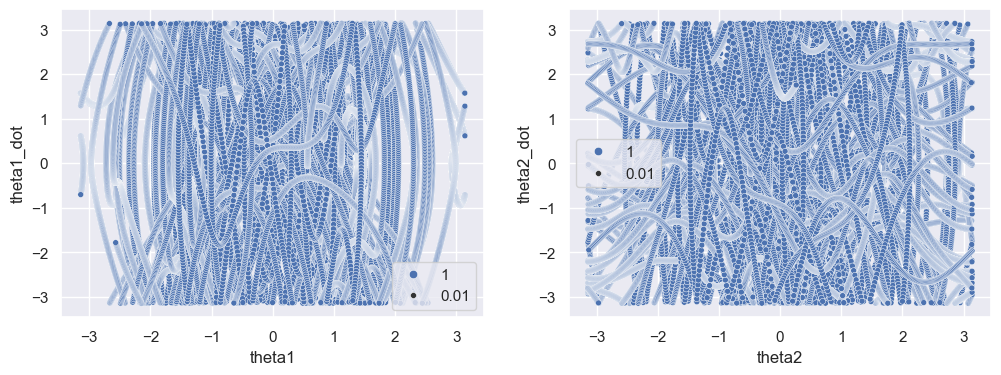

In [53]:
# Configuratie
t_end = 80
dt = 0.002
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
m1 = 1
m2 = 1
theta1 = math.radians(0)
theta2 = math.radians(10)

def normalise(array):
    return np.arctan2(np.sin(array), np.cos(array))

# Bereken resulterende data
results = get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2)

df = pd.DataFrame({"t": t, "theta1": normalise(results[:, 0]), "theta1_dot": normalise(results[:, 1]), "theta2": normalise(results[:, 2]), "theta2_dot": normalise(results[:, 3])})

fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4]))
sns.scatterplot(data=df, x='theta1', y='theta1_dot', ax=axs[0], size=0.01, hue=1)
sns.scatterplot(data=df, x='theta2', y='theta2_dot', ax=axs[1], size=0.01, hue=1)

plt.savefig("output/poincare.png")

Regressie van twee slingers:

0.000     1.570796
0.002     1.570777
0.004     1.570718
0.006     1.570620
0.008     1.570482
            ...   
19.990    0.668674
19.992    0.677055
19.994    0.685390
19.996    0.693678
19.998    0.701919
Name: Slinger 1, Length: 10000, dtype: float64


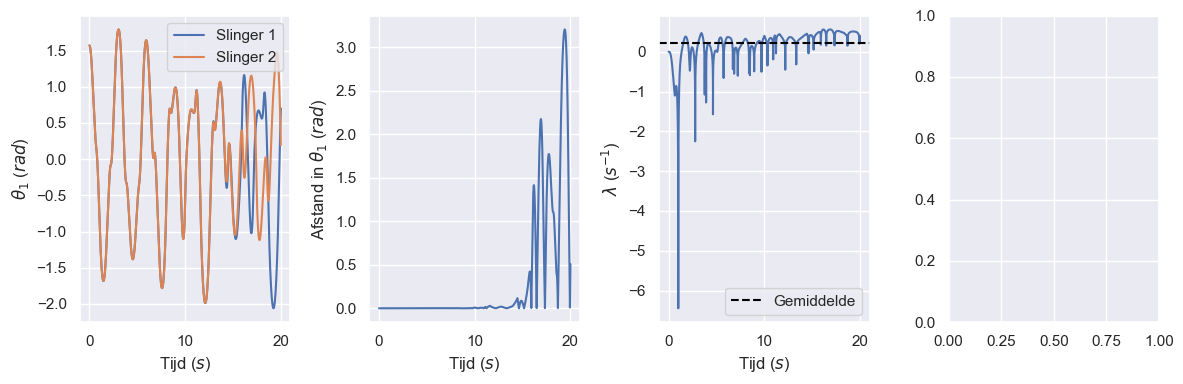

In [13]:

save_name = "output/regression.png"

pendulums_dataframe = pd.read_pickle("data/regression_pendulums.pkl")
distance_dataframe = pd.read_pickle("data/regression_distance.pkl")
lyapunov_dataframe = pd.read_pickle("data/regression_lyapunov.pkl")

# Maak lijnen voor grafiek aan
fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4, 4, 4]))

# Figuur 1: Theta2 tegen tijd
plot1 = sns.lineplot(pendulums_dataframe, ax=axs[0], dashes = False)
plot1.set(xlabel=r"Tijd ($s$)", ylabel=r"$\theta_1$ ($rad$)")
sns.move_legend(plot1, "upper right")

plot2 = sns.lineplot(distance_dataframe, ax=axs[1], legend=False)
plot2.set(xlabel=r"Tijd ($s$)", ylabel=r"Afstand in $\theta_1$ ($rad$)")

plot3 = sns.lineplot(lyapunov_dataframe, ax=axs[2], legend=False)
plot3.set(xlabel=r"Tijd ($s$)", ylabel=r"$\lambda$ ($s^{-1}$)")

axs[2].axhline(lyapunov_dataframe[0].mean(), label="Gemiddelde", color="black", linestyle="--")
axs[2].legend()

print(pendulums_dataframe["Slinger 1"])
# plot4 = sns.scatterplot()

fig.tight_layout()
plt.savefig(save_name)    

Lyapunov exponenten bij verschillende massa's:

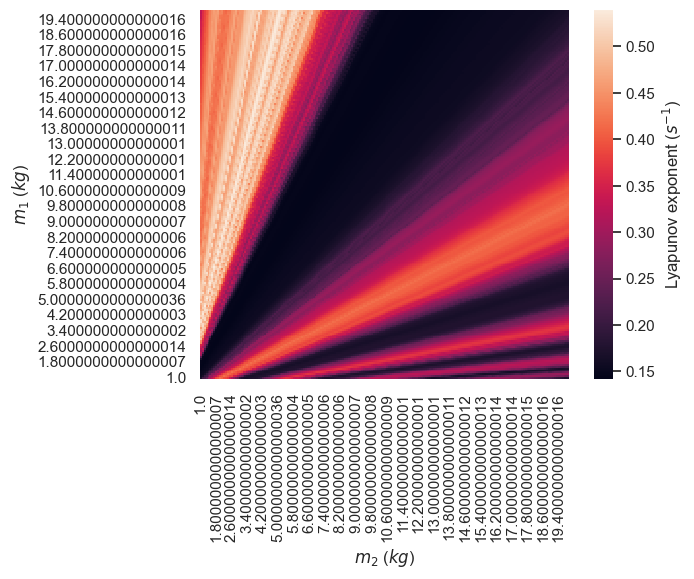

In [64]:
save_name = "output/regression_masses.png"

result_dataframe = pd.read_pickle("data/lyapunov_masses.pkl")

# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)
ax.set_aspect('equal','box')

heat_map = sns.heatmap(data=result_dataframe, cbar_kws={'label': r'Lyapunov exponent ($s^{-1}$)'})
heat_map.invert_yaxis()
heat_map.set(xlabel=r"$m_2$ ($kg$)", ylabel=r"$m_1$ ($kg$)")
plt.savefig(save_name)

Lyapunov exponenten bij verschillende lengtes:

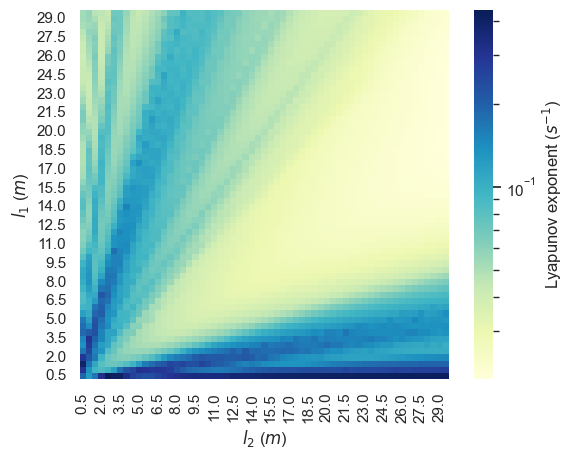

In [15]:
save_name = "output/lyapunov_lengths.png"

result_dataframe = pd.read_pickle("data/lyapunov_lengths.pkl")

# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)
ax.set_aspect('equal','box')

heat_map = sns.heatmap(data=result_dataframe, cbar_kws={'label': r'Lyapunov exponent ($s^{-1}$)'}, norm=LogNorm(vmin=result_dataframe.min().min(), vmax=result_dataframe.max().max()))
heat_map.invert_yaxis()
heat_map.set(xlabel=r"$l_2$ ($m$)", ylabel=r"$l_1$ ($m$)")

plt.savefig(save_name)

Lyapunov bij verschillende snelheden

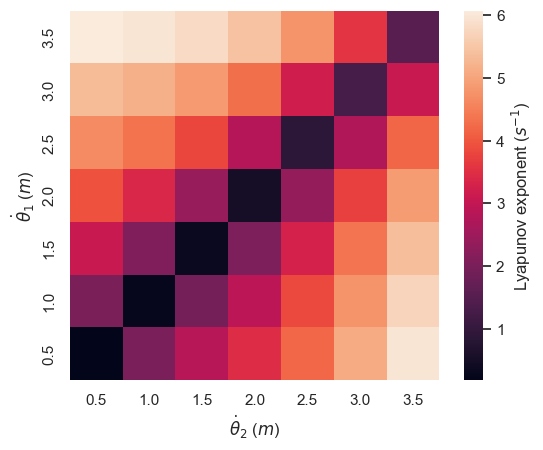

In [44]:
save_name = "output/regression_velocity.png"

result_dataframe = pd.read_pickle("data/lyapunov_velocity.pkl")

# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)
ax.set_aspect('equal','box')

heat_map = sns.heatmap(data=result_dataframe, cbar_kws={'label': r'Lyapunov exponent ($s^{-1}$)'})
heat_map.invert_yaxis()
heat_map.set(xlabel=r"$\dot{\theta}_2$ ($m$)", ylabel=r"$\dot{\theta}_1$ ($m$)")

plt.savefig(save_name)

# Animaties

Één dubbele slinger:

In [1]:
# Configuratie
t_end = 10
FPS = 24
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
m1 = 1
m2 = 1
theta1 = 2
theta2 = 2

# Bereken resulterende data
results = get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2)
x1, y1, x2, y2 = get_coordinates(results, l1, l2)

fig, (ax1, ax2) = plt.subplots(2)
pendulum_line, = ax1.plot([], [])
theta_2_line, = ax2.plot(t, np.abs(np.arctan2(np.cos(results[:, 2]), np.sin(results[:, 2]))))
theta_2_scroller = ax2.axvline(0)

timelogger = TimeLogger(FPS * t_end, "Animating frames")
def animate(frame):
    pendulum_line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
    theta_2_scroller.set_xdata(t[frame])
    timelogger.update()

ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

ani = animation.FuncAnimation(fig, animate, frames=len(results), interval=1000/FPS)
ani.save("output/single_pendulum.mp4")
Video("output/single_pendulum.mp4")

NameError: name 'np' is not defined

Regressie van twee slingers

C:\Users\Kevin\AppData\Local\Temp\ipykernel_24104\2749308038.py:60: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  distance_time_scroller.set_xdata(frame / FPS)
C:\Users\Kevin\AppData\Local\Temp\ipykernel_24104\2749308038.py:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lyapunov_time_scroller.set_xdata(frame / FPS)


KeyboardInterrupt: 

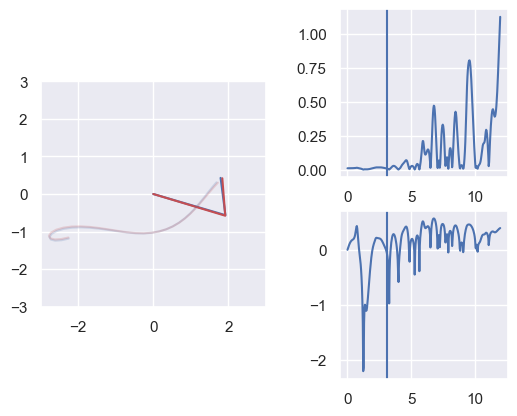

In [58]:
# Animatie configuratie
t_end = 12
FPS = 30
t = np.arange(0, t_end, 1/FPS)
trace_time = 1
save_name = "output/regression.mp4"

# Slingers configuratie
l1 = 2
l2 = 1
m1 = 2
m2 = 1
theta1 = 2
theta2 = 0
dtheta = 0.01

# Bereken resulterende data
results1 = get_resulting_array(t, theta1 - dtheta / 2, 0, theta2 - dtheta / 2, 0, m1, m2, l1, l2)
results2 = get_resulting_array(t, theta1 + dtheta / 2, 0, theta2 + dtheta / 2, 0, m1, m2, l1, l2)
x1_1, y1_1, x2_1, y2_1 = get_coordinates(results1, l1, l2)
x1_2, y1_2, x2_2, y2_2 = get_coordinates(results2, l1, l2)

distances = get_differences(results1, results2)
lyapunov_values = get_lyapunov_values(t, distances)

# Maak lijnen voor grafiek aan
fig = plt.figure()
ax1 = plt.subplot(2, 2, (1, 3))
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 4, sharex=ax2)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

pendulum_line1, = ax1.plot([], [], color="b")
pendulum_line2, = ax1.plot([], [], color="r")
pendulum_trace_line1, = ax1.plot([], [], color="b", alpha=0.2)
pendulum_trace_line2, = ax1.plot([], [], color="r", alpha=0.2)

distance_line = ax2.plot(t, distances[:, 0])
distance_time_scroller = ax2.axvline(0)

lyapunov_line, = ax3.plot(t, lyapunov_values)
lyapunov_time_scroller = ax3.axvline(0)

timeLogger = TimeLogger(len(t), "Frame animation")

# Definieer de animatie functie
def animate(frame):
    trace_start_frame = np.clip(frame - trace_time * FPS, 0, len(t))
    
    pendulum_line1.set_data([0, x1_1[frame], x2_1[frame]], [0, y1_1[frame], y2_1[frame]])
    pendulum_line2.set_data([0, x1_2[frame], x2_2[frame]], [0, y1_2[frame], y2_2[frame]])
    
    pendulum_trace_line1.set_data(x2_1[trace_start_frame:frame], y2_1[trace_start_frame:frame])
    pendulum_trace_line2.set_data(x2_2[trace_start_frame:frame], y2_2[trace_start_frame:frame])
        
    distance_time_scroller.set_xdata(frame / FPS)
    lyapunov_time_scroller.set_xdata(frame / FPS)
    
    timeLogger.update()

# Maak een animatie, sla hem op en laat hem zien
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=1000/FPS)
ani.save(save_name)
Video(save_name)